In [16]:
import numpy as np
from google.colab.patches import cv2_imshow
from math import log
import matplotlib.pyplot as plt
import pandas as pd
import time
import pywt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from skimage import io, color
import pywt
from PIL import Image

##Classe

In [29]:
'''
Ce code définit les classes qui vont être utilisées par la suite dans le projet 
'''


#la Classe random contient les fonctions qui simulent les variables aléatoires qui seront utilisée pour étudier les données simulés.

print("test")
class random:  
    def matrix_normal(n,p,mu=0,sigma=1):  # n est le nombre de lignes et p le nombre des colonnes, mu est la moyenne et sigma est l'écart type
        return (np.random.randn(n,p)*(sigma**2))+mu
    def vect_normal(n,mu=0,sigma=1):
        return (np.random.randn(n)*(sigma**2))+mu
    def beta(a,s,n): # s et a sont à préciser tel que s= 0,1*p et n> 2*s*log(p/2) pour commencer on peut utilisr a=1
        return a*(np.random.binomial(1,s/n , size=(n,)))
    def outcome(n,p,a,s,mu=0,sigma=1):
        X=random.matrix_normal(n,p,mu,sigma)
        beta=random.beta(a,s,p)
        epsilon=random.vect_normal(n,mu,sigma)
        Y=X @ beta+epsilon
        return Y,X,beta,epsilon


#la classe algo contient les algorithmes qui seront utilisés nottament ISTA et IHT
class algo:


    def HardThreshold(x,lamda):
        return x*(np.abs(x)>=lamda)
    def SoftThreshold(x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
    def indice_sparsite(vector):
      return(1-(float(np.count_nonzero(vector))/float(vector.size)))


    def IHT(X, Y,beta=np.zeros(1) ,C=0.9,step=0.0000001,max_iterations=3000,lamda=0.1, tol=1e-6,sparse='False'):
        n,m=X.shape
        Z,beta_hat=np.zeros(m),np.ones(m)
        loss=[]
        cost=[]
        check_vect=np.zeros(m)
        test=np.zeros(1)
        sparsity=[]
        if np.array_equal(beta, test, equal_nan=False):
          beta=beta_hat.copy()
          print('We are in the unknow beta case,the cost function is not significant')
        start_time = time.time()        
        for i in range(max_iterations):
            Z=beta_hat+(step*(X.T)@(Y-X@beta_hat))
            beta_hat=algo.HardThreshold(Z, lamda)
            cost.append(np.linalg.norm(-beta+beta_hat))
            sparsity.append(algo.indice_sparsite(beta_hat))
            while lamda > 2:
              lamda*=C
            loss.append(np.linalg.norm(Y-(X@beta_hat)))
            #if np.linalg.norm(beta_hat -check_vect ) < tol:
                #break
        end_time = time.time()
        time_taken = end_time - start_time
        print("IHT execution time :", time_taken, "seconds")

        return beta_hat,cost,loss,sparsity

    def ISTA(X, Y,beta=np.zeros(1) ,step=0.0001,max_iterations=3000,lamda=0.01, tol=1e-6,):
        n,m=X.shape
        Z,beta_hat=np.zeros(m),np.ones(m)
        check_vect=np.zeros(m)
        test=np.zeros(1)
        cost=[]
        loss=[]
        sparsity=[]
        if np.array_equal(beta, test, equal_nan=False):
          beta=beta_hat.copy()
          print('We are in the unknow beta case,the cost function is not significant')
        start_time = time.time()
        for i in range(max_iterations):
            Z=beta_hat+(step*(X.T)@(Y-X@beta_hat))
            beta_hat=algo.SoftThreshold(Z, lamda)
            cost.append(np.linalg.norm(-beta+beta_hat))
            loss.append(np.linalg.norm(Y-(X@beta_hat)))
            sparsity.append(algo.indice_sparsite(beta_hat))
            #if np.linalg.norm(beta_hat -check_vect ) < tol:
                #break
        end_time = time.time()
        time_taken = end_time - start_time
        print("ISTA execution time :", time_taken, "seconds")
        return beta_hat,cost,loss,sparsity

class image_processing:
    def image_tansformation_to_spare_vector_BW(img_path, wavelet_type='haar', threshold=20):
    # telecharger l'image
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # on applique la transofomation en ondellettes de dimension 2
      coeffs = pywt.dwt2(img, wavelet_type)
      cA, (cH, cV, cD) = coeffs
    #on stock les dimention de ces vecteurs afin de pouvoir les récuperer dans un second lieu
      coeff_size=[cA.size,cH.size,cV.size]
      coeff_shape=[cA.shape,cH.shape,cV.shape,cD.shape]
    # construire notre vecteur sparse qui contient toutes les infomations
      coef_vec = np.concatenate((cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()))
      coef_vec[np.abs(coef_vec) < threshold] = 0
      return coef_vec,coeff_size,coeff_shape


    def image_from_sparse_vector_BW(coef_vec,coeff_size,coeff_shape, wavelet_type='haar'):
    # on récupere les vecteurs que la transofomation en ondelettes a sorti
      cA_size=coeff_size[0]
      cH_size=coeff_size[1]
      cV_size=coeff_size[2]
      cA_thresh = coef_vec[:cA_size].reshape(coeff_shape[0])
      cH_thresh = coef_vec[cA_size:cA_size+cH_size].reshape(coeff_shape[1])
      cV_thresh = coef_vec[cA_size+cH_size:cA_size+cH_size+cV_size].reshape(coeff_shape[2])
      cD_thresh = coef_vec[cA_size+cH_size+cV_size:].reshape(coeff_shape[2])
      coeffs_thresh = cA_thresh, (cH_thresh, cV_thresh, cD_thresh)
      # on reconstruit l'image
      img_thresh = pywt.idwt2(coeffs_thresh, wavelet_type)
      return img_thresh


    def compress_image_RGB(img_path, wt='haar',threshold=20 ,n_lev=2, compression_value=0):
    # Load image
      imgRGB = io.imread(img_path)

    # Convert to YCbCr
      imgYCbCR = color.rgb2ycbcr(imgRGB)
      Y = imgYCbCR[:, :, 0]
      Cb = imgYCbCR[:, :, 1]
      Cr = imgYCbCR[:, :, 2]

    # Perform wavelet transform
      Y_coeff_arr, Y_coeff_slices = pywt.coeffs_to_array(pywt.wavedec2(Y, wavelet=wt, level=n_lev))
      Cb_coeff_arr, Cb_coeff_slices = pywt.coeffs_to_array(pywt.wavedec2(Cb, wavelet=wt, level=n_lev))
      Cr_coeff_arr, Cr_coeff_slices = pywt.coeffs_to_array(pywt.wavedec2(Cr, wavelet=wt, level=n_lev))
      Y_coeff_arr,Cb_coeff_arr, Cr_coeff_arr, = np.array(Y_coeff_arr) ,np.array(Cb_coeff_arr), np.array(Cr_coeff_arr)


    # Compress wavelet coefficients
      Y_coeff_arr_filt = np.where(np.abs(Y_coeff_arr) > compression_value * np.max(np.abs(Y_coeff_arr)),Y_coeff_arr,0)
      Cb_coeff_arr_filt = np.where(np.abs(Cb_coeff_arr) > compression_value * np.max(np.abs(Cb_coeff_arr)), Cb_coeff_arr, 0)
      Cr_coeff_arr_filt = np.where(np.abs(Cr_coeff_arr) > compression_value * np.max(np.abs(Cr_coeff_arr)), Cr_coeff_arr, 0)
      coeff_size=[Y_coeff_arr_filt.size,Cb_coeff_arr_filt.size,Cr_coeff_arr_filt.size]

      coeff_shape=[Y_coeff_arr_filt.shape, Cb_coeff_arr_filt.shape, Cr_coeff_arr_filt.shape]
      coef_vec=np.concatenate((Y_coeff_arr_filt.flatten(), Cb_coeff_arr_filt.flatten(),Cr_coeff_arr_filt.flatten()))
      coef_vec[np.abs(coef_vec) < threshold] = 0
      slices=[Y_coeff_slices,Cb_coeff_slices,Cr_coeff_slices]
      return coef_vec, slices,coeff_size,coeff_shape



    def decompress_photo_RGB(coef_vec,slices,coeff_size,coeff_shape,wt='haar'):
      Y_shape = coeff_shape[0]
      Cb_shape = coeff_shape[1]
      Cr_shape = coeff_shape[2]
      #reconstruct matrices
      Y_coeff_slices = slices[0]
      Cb_coeff_slices = slices[1]
      Cr_coeff_slices = slices[2]
  
      Y_coeff_arr_filt = coef_vec[0:coeff_size[0]].reshape(Y_shape)
      Cb_coeff_arr_filt = coef_vec[coeff_size[0]:coeff_size[0] + coeff_size[1]].reshape(Cb_shape)
      Cr_coeff_arr_filt = coef_vec[coeff_size[0] + coeff_size[1]:].reshape(Cr_shape)
      # Reconstruct images from compressed wavelet coefficients
      Y_compressed = pywt.waverec2(pywt.array_to_coeffs(Y_coeff_arr_filt, Y_coeff_slices, output_format='wavedec2'), wavelet=wt)
      Cb_compressed = pywt.waverec2(pywt.array_to_coeffs(Cb_coeff_arr_filt, Cb_coeff_slices, output_format='wavedec2'), wavelet=wt)
      Cr_compressed = pywt.waverec2(pywt.array_to_coeffs(Cr_coeff_arr_filt, Cr_coeff_slices, output_format='wavedec2'), wavelet=wt)

      # Convert back to RGB and stack the channels
      img_compressed = color.ycbcr2rgb(np.dstack((Y_compressed, Cb_compressed, Cr_compressed)))
      img_compressed = Image.fromarray((img_compressed* 255).astype(np.uint8))

      return img_compressed


test


##données simulées


Les paramètres: n_it pour le nombres d'itération qu'on souhaite fixer pour l'execution des différents algorithmes 

In [ ]:
n_it=700

les paramètres pour définir la taille et les caractéristiques des vecteurs qui représentent les données simulées. p et s représentent la taille de la matrice X qui simule un vecteur normal de paramètres $E$[X]=1 et $V$[X]=0. 
Quant à s et a sont les paramètres qu'il faut préciser pour la simulation de la variable $\beta$ qui simule un vecteur aléatoire de lois binomiale. s et a sont à préciser tel que s= 0,1*p et p> 2*s*log(n/2). $\alpha$ est un vecteur qui contient les différentes valeurs de alpha qu'on va utiliser pour exécuter les différents algorithmes. 

In [ ]:
n=4000
p=6000
a=10
s=0.1*p
lamda_ista=10
lamda_IHT=300
C=0.88
step=0.0001

In [ ]:
Y,X,beta,epsilon=random.outcome(n,p,a,s)

##Data visualisation
Dans cette partie on essaye de représenter la fonction coût pour 100 valeurs différentes d'alpha. Dans un premier temps on fait la représentation pour l'algorithme ISTA et FISTA d'un coté.Dans un second temps on fait la repésentation des 2 courbes superposées. Cette visualisation permet de suggérer que l'algorithme FISTA converge plus rapidement. La section suivante vise à mener une étude statistique sur ces deux fonction de coût

##ISTA

In [ ]:
betahat_ista,cost_ista,loss_ista,sparsity_ista=algo.ISTA(X,Y,beta,max_iterations=n_it)
nbr_it = list(range(1,len(cost_ista)+1))

ISTA execution time : 88.2931981086731 seconds


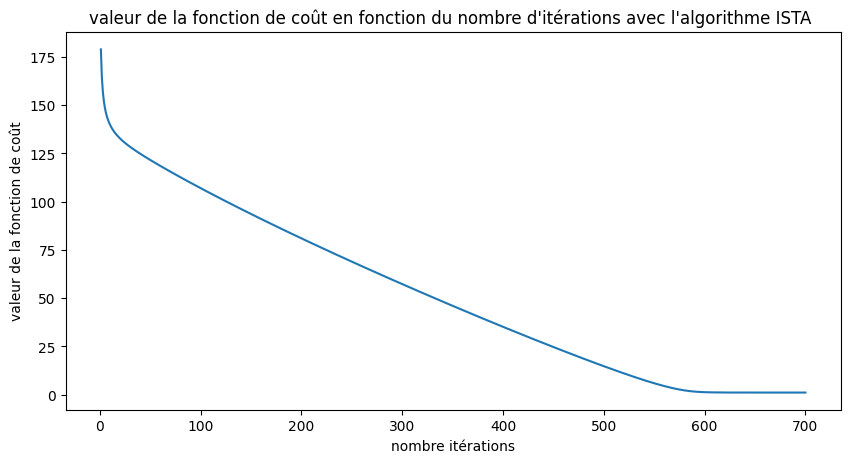

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,cost_ista)
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations avec l'algorithme ISTA ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

#ce graphique représente la vitesse de convergence en fonction du nombre d'itération de la fonction de coût de l'algorithme ISTA

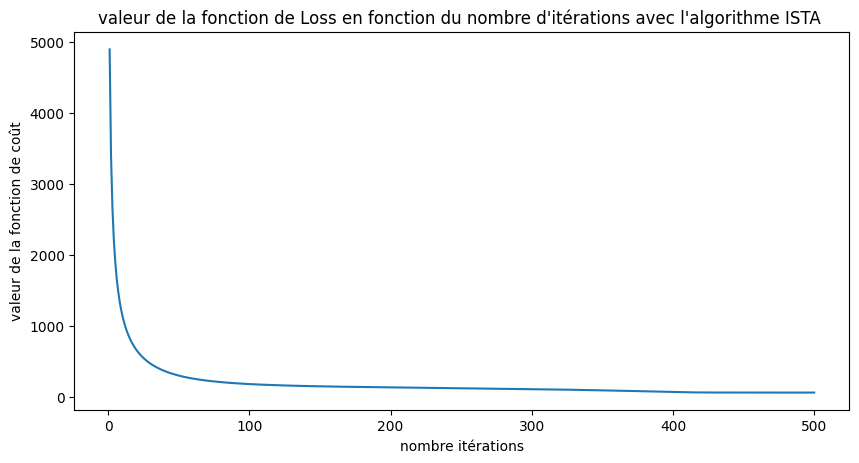

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,loss_ista)
plt.title("valeur de la fonction de Loss en fonction du nombre d'itérations avec l'algorithme ISTA ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

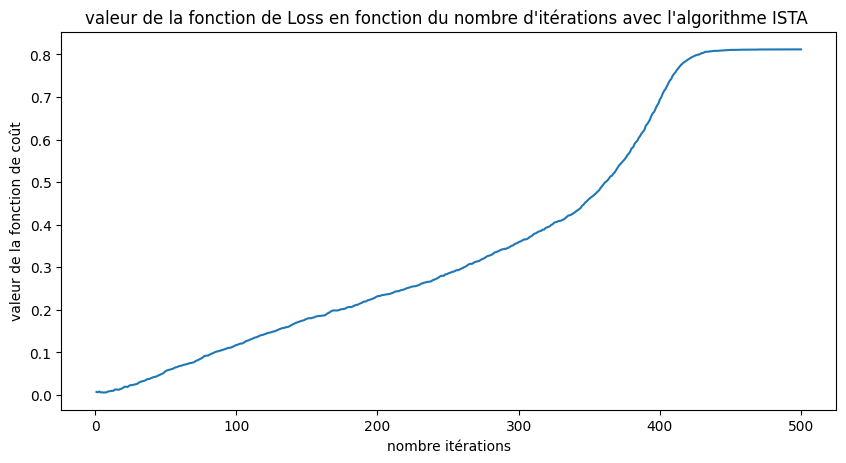

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,sparsity_ista)
plt.title("valeur de la fonction de Loss en fonction du nombre d'itérations avec l'algorithme ISTA ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

##IHT

In [ ]:
betahat_iht,cost_iht,loss_iht,sparsity_IHT=algo.IHT(X, Y,beta ,C,step,max_iterations=n_it,lamda=lamda_IHT)
nbr_it_h = list(range(1,len(cost_iht)+1))

IHT execution time : 85.20542049407959 seconds


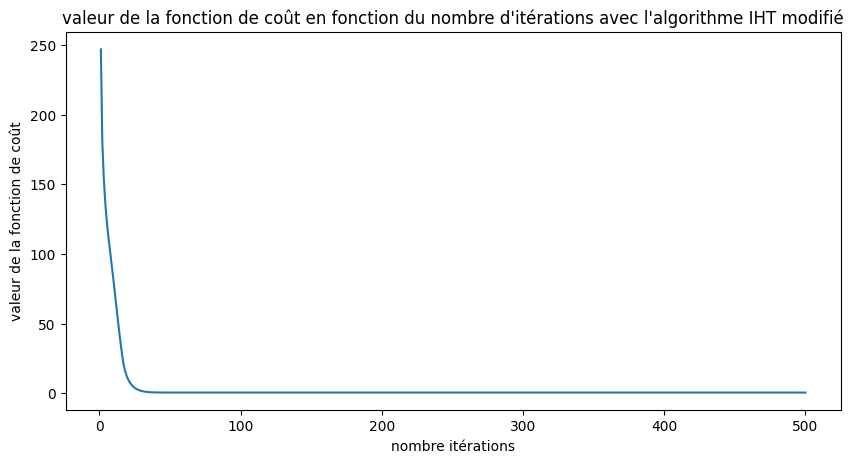

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it_h,cost_iht)
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations avec l'algorithme IHT modifié")  # Titre du graphique)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

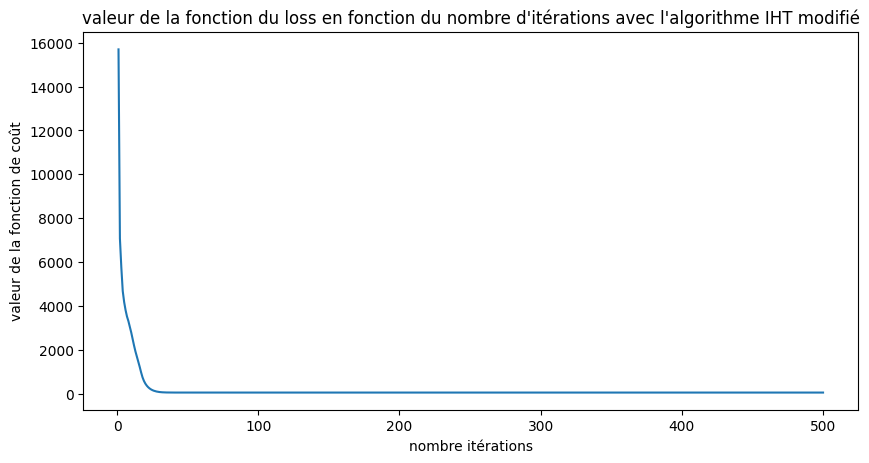

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it_h,loss_iht)
plt.title("valeur de la fonction du loss en fonction du nombre d'itérations avec l'algorithme IHT modifié")  # Titre du graphique)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

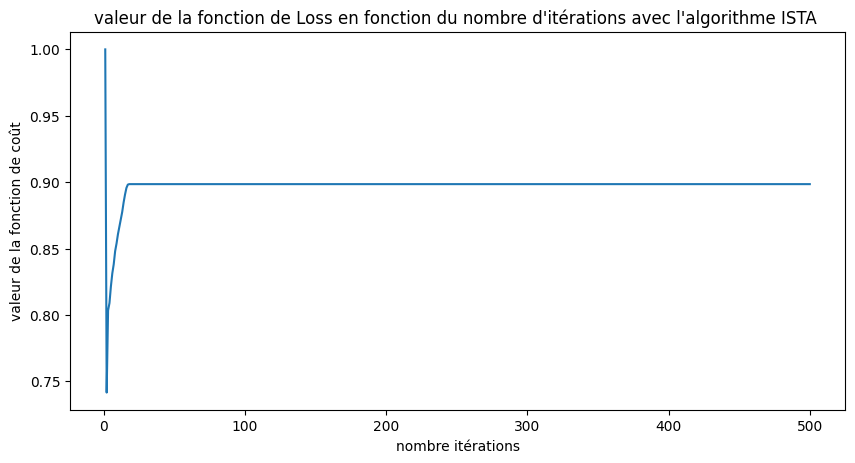

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(nbr_it,sparsity_IHT)
plt.title("valeur de la fonction de Loss en fonction du nombre d'itérations avec l'algorithme ISTA ")  # Titre du graphique
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.show()

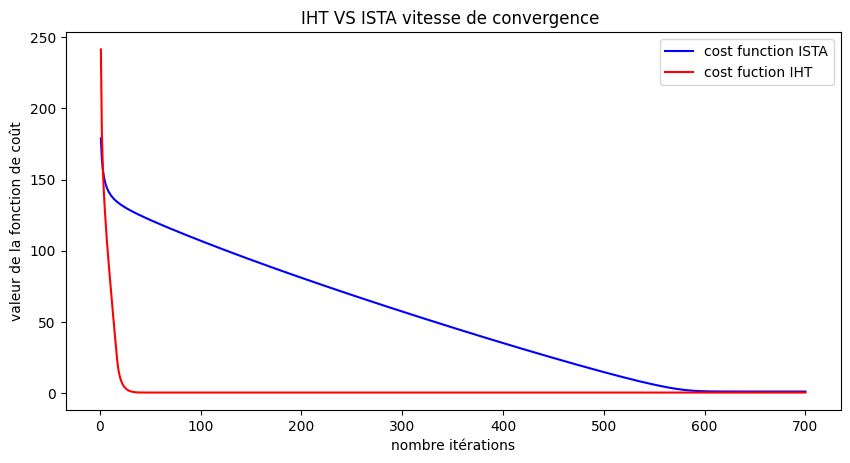

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.title("IHT VS ISTA vitesse de convergence ")
plt.plot(nbr_it,cost_ista, color='blue', label='cost function ISTA')
plt.plot(nbr_it_h,cost_iht, color='red',label='cost fuction IHT')
plt.legend(loc='upper right')
plt.show()

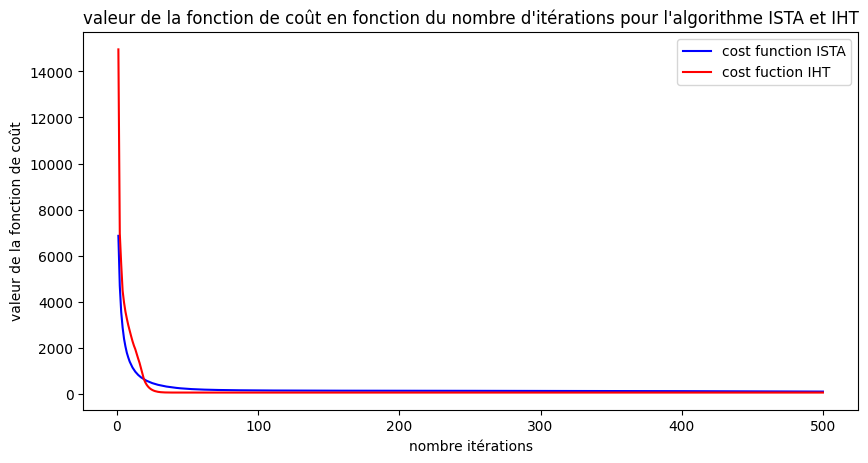

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.ylabel('valeur de la fonction de coût')  # Titre de l'axe y
plt.xlabel('nombre itérations')
plt.title("valeur de la fonction de coût en fonction du nombre d'itérations pour l'algorithme ISTA et IHT")
plt.plot(nbr_it,loss_ista, color='blue', label='cost function ISTA')
plt.plot(nbr_it_h,loss_iht, color='red',label='cost fuction IHT')
plt.legend(loc='upper right')
plt.show()

#Ondelettes

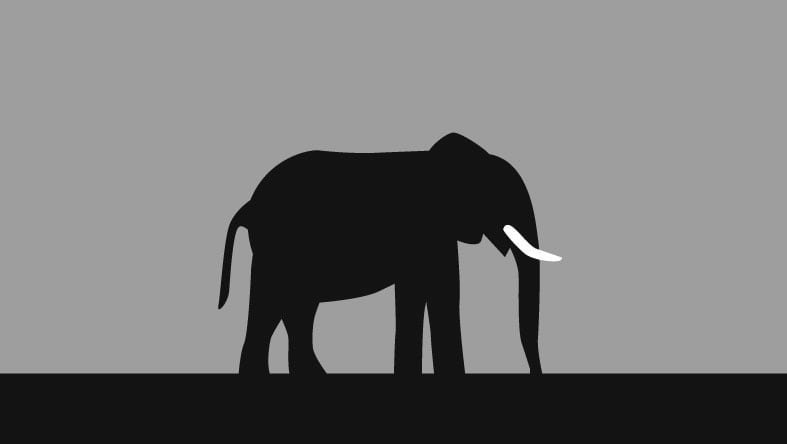

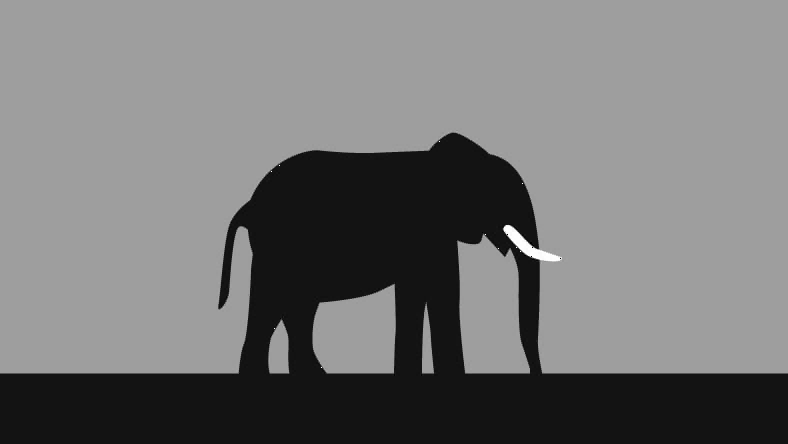

In [ ]:
from google.colab.patches import cv2_imshow
# Load image and get sparse vector and image shape
img_path = 'random.jpg'
coef_vec,coeff_size,coeff_shape= image_processing.image_tansformation_to_spare_vector_BW(img_path)

# Reconstruct image from sparse vector and image shape
img_thresh = image_processing.image_from_sparse_vector_BW(coef_vec,coeff_size,coeff_shape)

# Display original and thresholded images
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)
cv2_imshow(img_thresh.astype(np.uint8))

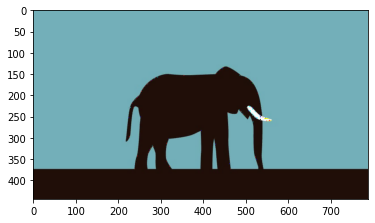

In [31]:
coef_vec,slices,coeff_size,coeff_shape =image_processing.compress_image_RGB('random.jpg')
img = image_processing.decompress_photo_RGB(coef_vec,slices,coeff_size,coeff_shape,wt='haar')
plt.imshow(img)